In [88]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
from scipy.sparse import vstack
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import StandardScaler

Ссылка на соревнование Kaggle https://www.kaggle.com/competitions/store-sales-time-series-forecasting

<h3 align='left'>Функция формирования посылки на Kaggle</h3>

In [89]:
def kaggle_sub(y_pred):
    submission = pd.read_csv('sample_submission.csv')
    submission['sales'] = y_pred
    submission.to_csv('submission', index=False)

<h3 align='left'>Считывание и первичная обработка данных</h3>

In [90]:
test = pd.read_csv('test.csv', index_col='id')
train = pd.read_csv('train.csv', index_col='id')
holidays_events = pd.read_csv('holidays_events.csv') #праздники и события
oil = pd.read_csv('oil.csv')  #ежедневная цена на нефть
stores = pd.read_csv('stores.csv') #магазины

In [91]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [92]:
print('Train: ', min(train['date']), max(train['date']), sep='\n')
print('Test: ', min(test.date),max(test.date), sep='\n')

Train: 
2013-01-01
2017-08-15
Test: 
2017-08-16
2017-08-31


In [93]:
#Объединяем train и test
train_size = train.shape[0]
data = pd.concat([train, test], axis=0)

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 138.7+ MB


In [95]:
data.isnull().sum() #пропущенных значений нет

date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
dtype: int64

In [96]:
#Меняем формат даты, добавляем столбцы
data.date = pd.to_datetime(data.date)
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
data['dayofmonth'] = data.date.dt.day
data['dayofweek'] = data.date.dt.dayofweek

<h3 align='left'>Продажи по категориям товаров</h3>

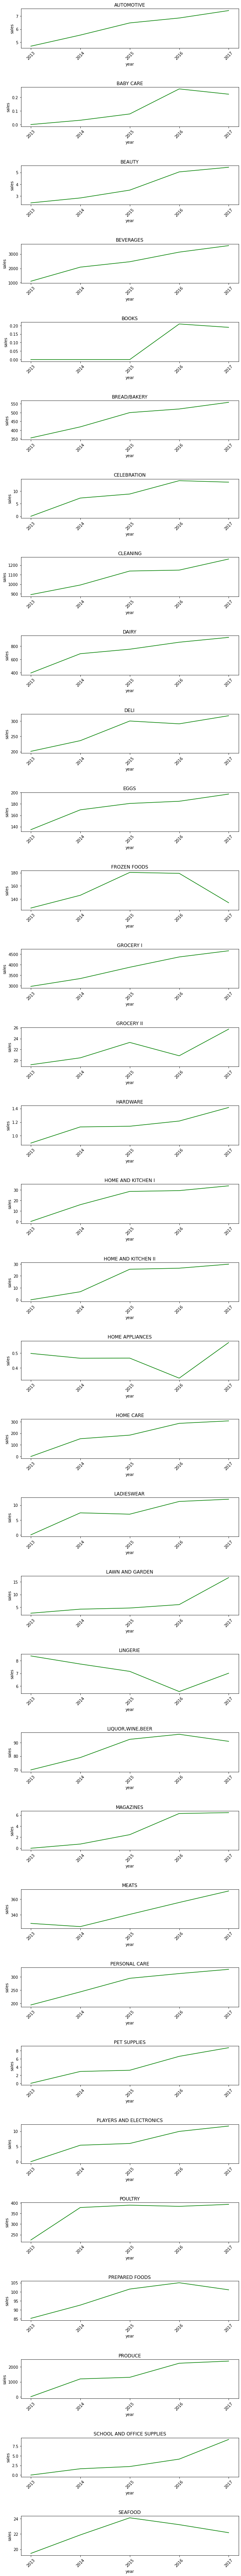

In [97]:
#Средние продажи по годам
graph_df = data.iloc[:train_size, :]
families = graph_df['family'].unique()
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=1)

for i, v in enumerate(families):
    ax = fig.add_subplot(len(families), 1,i+1)
    graph_df[graph_df['family'] == v].groupby('year').mean()['sales'].plot(color='green')
    plt.title(v)
    plt.xticks(np.arange(graph_df['year'].unique().min(), graph_df['year'].unique().max()+1), rotation=45)
    plt.ylabel('sales');



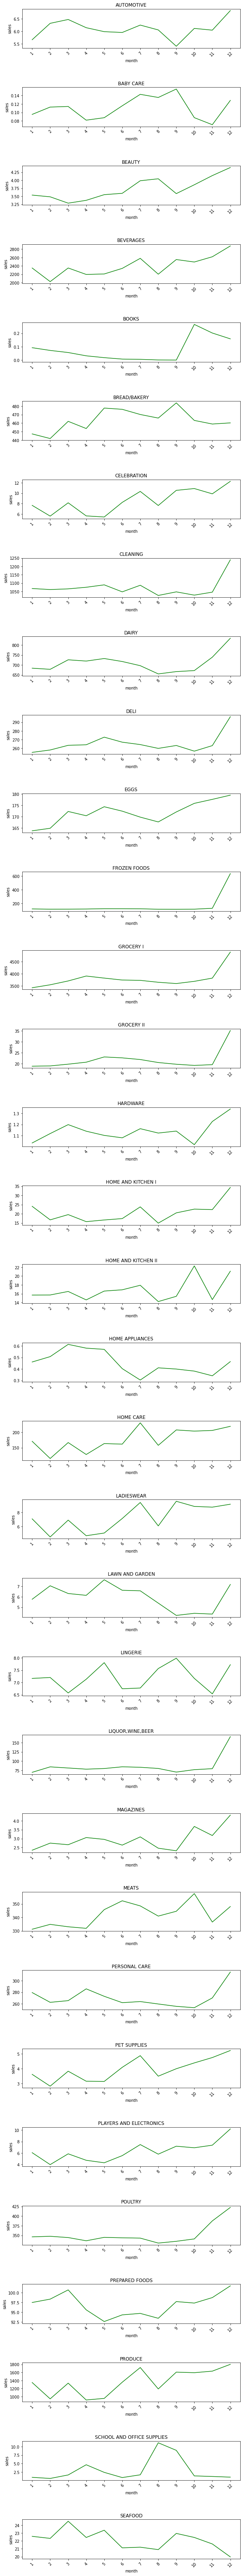

In [98]:
#Средние продажи по месяцам
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=1)

for i, v in enumerate(families):
    ax = fig.add_subplot(len(families), 1,i+1)
    graph_df[graph_df['family'] == v].groupby('month').mean()['sales'].plot(color='green')
    plt.title(v)
    plt.xticks(np.arange(graph_df['month'].unique().min(), graph_df['month'].unique().max()+1), rotation=45)
    plt.ylabel('sales');

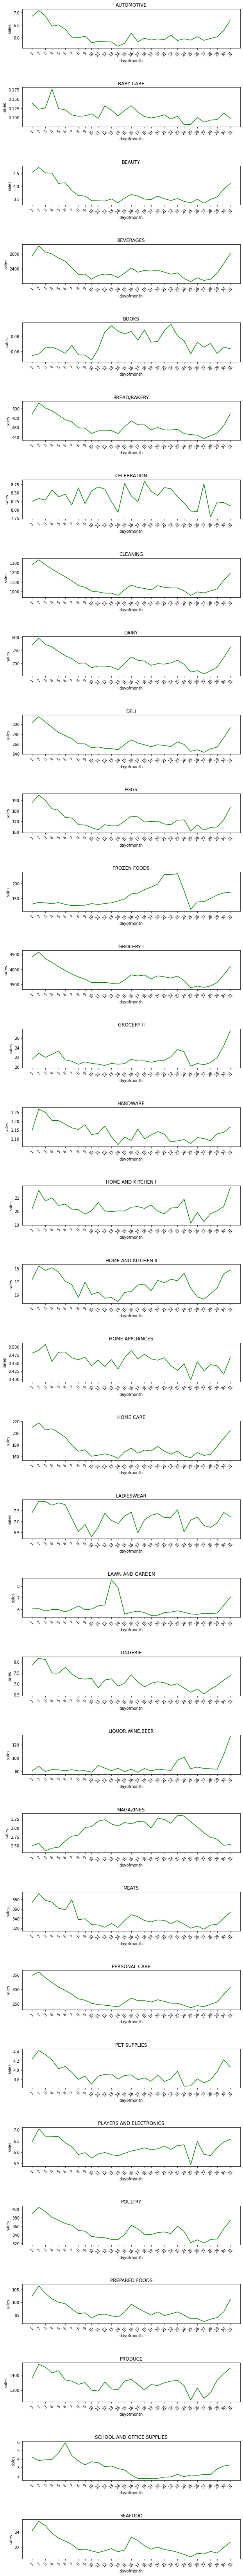

In [99]:
#Средние продажи по дням месяца
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=1)

for i, v in enumerate(families):
    ax = fig.add_subplot(len(families), 1,i+1)
    graph_df[graph_df['family'] == v].groupby('dayofmonth').mean()['sales'].plot(color='green')
    plt.title(v)
    plt.xticks(np.arange(graph_df['dayofmonth'].unique().min(), graph_df['dayofmonth'].unique().max()+1), rotation=45)
    plt.ylabel('sales');

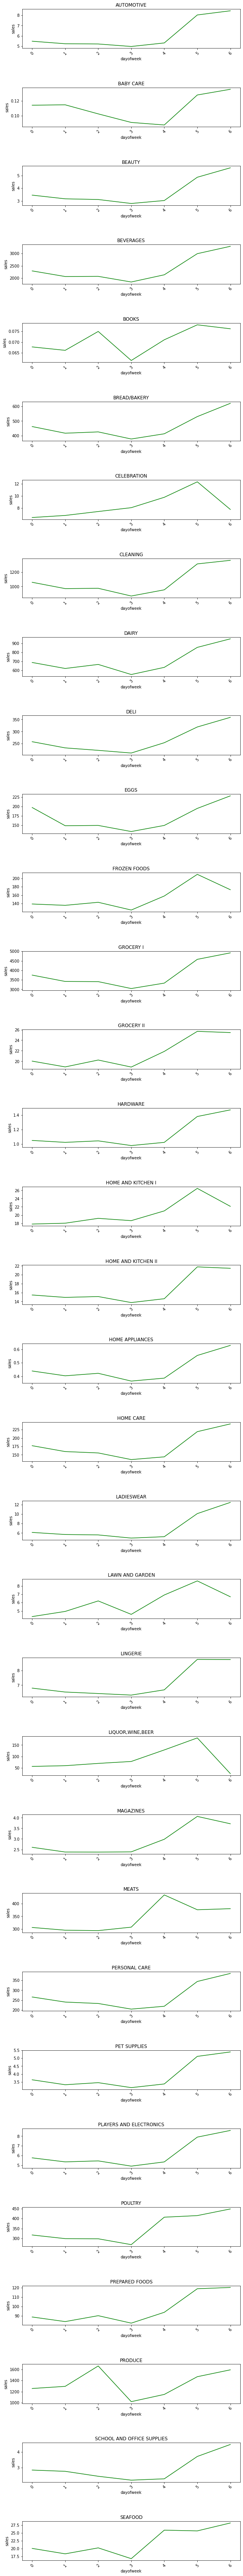

In [100]:
#Средние продажи по дням недели
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=1)

for i, v in enumerate(families):
    ax = fig.add_subplot(len(families), 1,i+1)
    graph_df[graph_df['family'] == v].groupby('dayofweek').mean()['sales'].plot(color='green')
    plt.title(v)
    plt.xticks(np.arange(graph_df['dayofweek'].unique().min(), graph_df['dayofweek'].unique().max()+1), rotation=45)
    plt.ylabel('sales');

В большинстве категорий товаров продажи от года к году растут, наблюдаются пики в начале и конце месяца, а также в конце недели. Часто наблюдается тренд по увеличению продаж в середине месяца, т.к. это день зарплаты

<h3 align='left'>Holidays</h3>

In [101]:
# holidays_events[holidays_events['type'] == 'Transfer']  #день празднования
# holidays_events[holidays_events['transferred'] == True] #перенесенный день, схожий с обычным рабочим 
# holidays_events[holidays_events['type'] == 'Additional'] #дни, добавленные к календарным праздникам
# holidays_events[holidays_events['type'] == 'Work Day'] #рабочие дни в выходной, выходной переносится в Additional
# holidays_events[holidays_events['type'] == 'Bridge'] #дни добавленные к календарным праздникам, совпадает с Additional

In [102]:
#Удаляем перенесенные дни, т.к. они схожи с обычными
holidays_events = holidays_events[holidays_events['transferred'] == False]

#Избавляемся от Bridge, т.к. это дубль Additional
holidays_events['type'] = holidays_events['type'].apply(lambda x: None if x == 'Bridge' else x)
holidays_events = holidays_events.dropna()

In [103]:
#Национальные праздники и события
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

National_holidays = holidays_events[(holidays_events['locale'] == 'National') & (holidays_events['type'] != 'Work Day') \
                                 & (holidays_events['type'] != 'Event')]
National_holidays_date = National_holidays['date'].value_counts().index
data['National_holidays'] = [1 if date in National_holidays_date else 0 for date in data['date']]


National_events = holidays_events[(holidays_events['locale'] == 'National') & (holidays_events['type'] == 'Event')]
National_events_date = National_events['date'].value_counts().index
data['National_events'] = [1 if date in National_events_date else 0 for date in data['date']]


National_workday = holidays_events[(holidays_events['locale'] == 'National') & (holidays_events['type'] == 'Work Day')]
National_workday_date = National_workday['date'].value_counts().index
data['National_work_day'] = [1 if (date in National_workday_date) or (dayofweek < 5 and holidays == 0) 
                             else 0 for date, dayofweek, holidays 
                             in zip(data['date'], data['dayofweek'], data['National_holidays'])]

In [104]:
#Добавляем stores к data 
data = data.merge(stores, how='left', left_on='store_nbr', right_on='store_nbr') 

#Региональные праздники ('locale_name' == 'state')
Regional_holidays = holidays_events[holidays_events['locale'] == 'Regional']\
                       .groupby(['date', 'locale_name'], as_index=False).count()[['date', 'locale_name']]

date_state = []
for i in range(Regional_holidays.shape[0]):
    date_state.append((Regional_holidays.iloc[i, 0], Regional_holidays.iloc[i, 1])) 

data['Regional_holidays'] = [1 if (date, state) in date_state 
                          else 0 for date, state in zip(data['date'], data['state'])]


In [105]:
#Местные праздники ('locale_name' == 'city')

Local_holidays = holidays_events[holidays_events['locale'] == 'Local']\
                       .groupby(['date', 'locale_name'], as_index=False).count()[['date', 'locale_name']]

date_city = []
for i in range(Local_holidays.shape[0]):
    date_city.append((Local_holidays.iloc[i, 0], Local_holidays.iloc[i, 1])) 

data['Local_holidays'] = [1 if (date, city) in date_city 
                          else 0 for date, city in zip(data['date'], data['city'])]


In [106]:
#День зарплаты
EndOfMonth = (pd.to_datetime(data['date'], format="%Y%m") + MonthEnd(0)).value_counts().index
data['Salary_day'] = [1 if dayofmonth == 15 or date in EndOfMonth else 0
                      for dayofmonth, date in zip(data['dayofmonth'], data['date'])]

<h3 align='left'>Продажи в праздничные и непраздничные
    дни</h3>

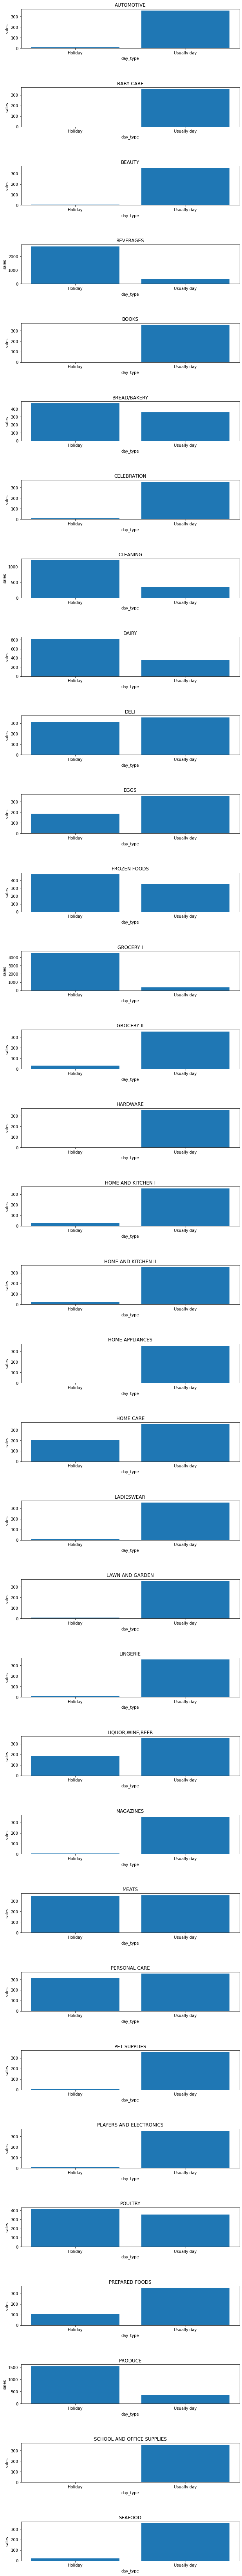

In [107]:
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=1)

for i, v in enumerate(families):
    ax = fig.add_subplot(len(families), 1,i+1)
    plt.bar(['Holiday', 'Usually day'], [data[(data['National_holidays'] == 1) & (data['family'] == v)]['sales'].mean(),
                                         data[data['National_holidays'] == 0 & (data['family'] == v)]['sales'].mean()])
    plt.title(v)
    plt.ylabel('sales')
    plt.xlabel('day_type');

Наблюдается увеличение числа продаж в праздники в категориях produce, poultry, groucery i, frozen food, dairy, cleaning, bread/beakery, beverages

<h3 align='left'>Oil</h3>

In [108]:
#Интерполируем пропущенные значения цены нефти
new_oil = pd.DataFrame([i for i in data['date'].value_counts().index], columns=['date'])
oil['date'] = pd.to_datetime(oil['date'])

oil = new_oil.merge(oil, how='left', on='date').sort_values(by=['date']).reset_index(drop=True)

oil['dcoilwtico'] = oil.dcoilwtico.interpolate(method='linear')
oil.loc[0, 'dcoilwtico'] = oil.loc[1, 'dcoilwtico']

In [109]:
data = data.merge(oil, how='left', left_on='date', right_on='date') 

<h3 align='left'>Зависимость продаж от стоимости нефти</h3>

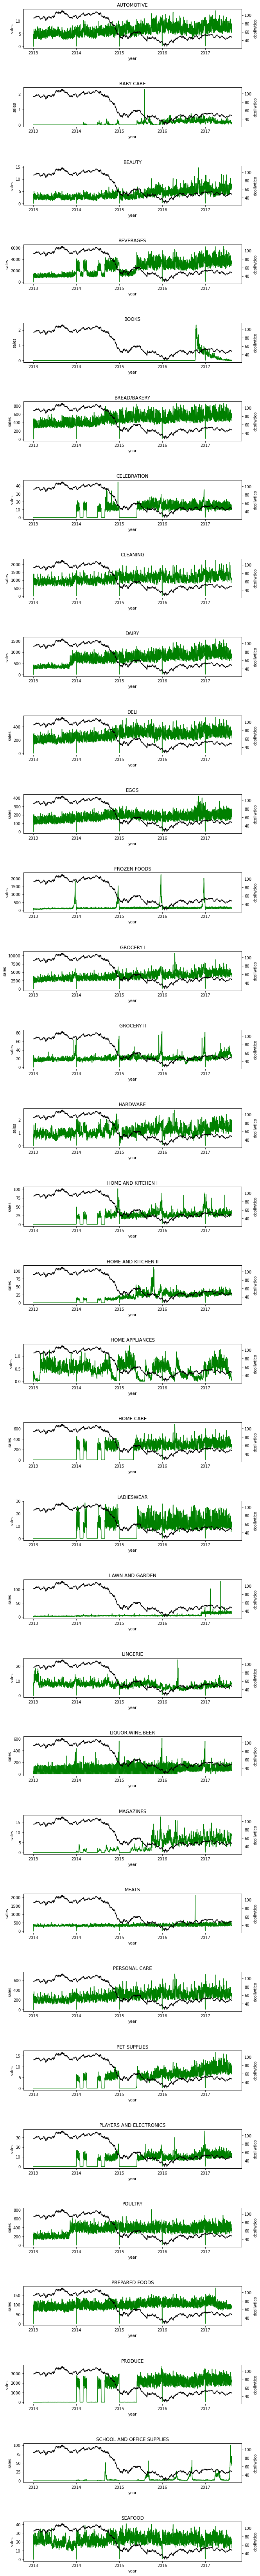

In [110]:
graph_df = data.iloc[:train_size, :]
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=1)

for i, v in enumerate(families):
    ax = fig.add_subplot(len(families), 1,i+1)
    ax1 = ax.twinx()
    ax.plot(graph_df[graph_df['family'] == v].groupby('date').mean()['sales'], color = 'green')
    ax1.plot(graph_df[graph_df['family'] == v].groupby('date').mean()['dcoilwtico'], color = 'black')
    ax.set_ylabel('sales')
    ax1.set_ylabel('dcoilwtico')
    ax.set_xlabel('year')
    plt.title(v);


Графики многих категорий товаров коррелируют со стоимостью нефти

<h3 align='left'>Зависимость продаж от рекламы
</h3>

<AxesSubplot:xlabel='onpromotion', ylabel='sales'>

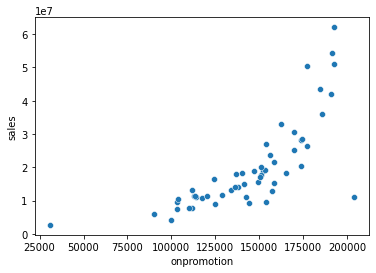

In [111]:
sns.scatterplot(data=graph_df.groupby('store_nbr')[['onpromotion','sales']].sum(), x='onpromotion', y='sales')

Можно заметить положительную корреляцию продаж и количества рекламируемых товаров

<h3 align='left'>Продажи по магазинам и городам</h3>

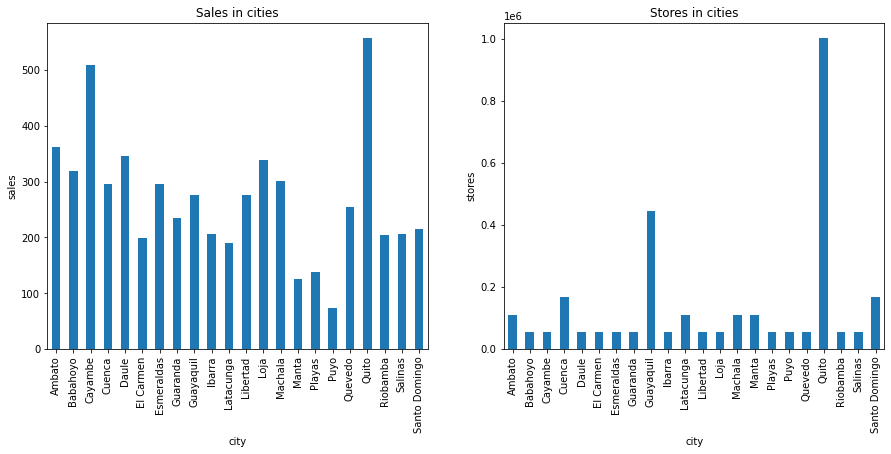

In [112]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1,2,1)
graph_df.groupby('city')['sales'].mean().plot(kind='bar')
plt.title('Sales in cities')
ax1 = plt.subplot(1,2,2)
graph_df.groupby('city')['store_nbr'].count().plot(kind='bar')
plt.title('Stores in cities')
ax.set_ylabel('sales')
ax1.set_ylabel('stores')
ax.set_xlabel('city');

<h3 align='left'>Подготовка данных</h3>

In [113]:
#Добавляем лаги: 16 - период прогнозирования, 1782 - число строк в одном дне (магазин + категория продукта)
train_size -= data[data['date'] == "2016-02-29"].shape[0] #Удаляем високосный год
data = data[data['date'] != "2016-02-29"]

data['Lag_16'] = data['sales'].shift(1782*16)
data['Lag_17'] = data['sales'].shift(1782*17)
data['Lag_18'] = data['sales'].shift(1782*18)
data['Lag_19'] = data['sales'].shift(1782*19)
data['Lag_20'] = data['sales'].shift(1782*20)
data["Lag_21"] = data['sales'].shift(1782*21)
data['Lag_22'] = data['sales'].shift(1782*22)
data['Lag_23'] = data['sales'].shift(1782*23)
data['Lag_24'] = data['sales'].shift(1782*24)
data['Lag_365'] = data['sales'].shift(1782*365)

In [114]:
data.isnull().sum().to_frame().rename(columns={0: 'NA_count'}).sort_values(by='NA_count', ascending=False)

,NA_count
Lag_365,650430
Lag_24,42768
Lag_23,40986
Lag_22,39204
Lag_21,37422
Lag_20,35640
Lag_19,33858
Lag_18,32076
Lag_17,30294
sales,28512


In [115]:
#Разделяем train, valid и test, удаляем NA и ненужные переменные, применяем One-Hot Encoding

data = pd.get_dummies(data.drop(['date'], axis=1))

train = data.iloc[:train_size, :].dropna()

X_train_full = train.drop(['sales'], axis=1)
y_train_full = np.log1p(train['sales']) #Логарифмируем целевую переменную для стабилизации дисперсии
X_test = data.iloc[train_size:, :].drop(['sales'], axis=1)



In [116]:
#Отмасштабируем данные для линейной регрессии
numbers = [i for i in X_train_full.dtypes.index if X_train_full.dtypes[i] == 'float' or X_train_full.dtypes[i] == 'int64']
X_train_scaled_full = X_train_full.copy()
X_test_scaled = X_test.copy()
for i in numbers:
    scaler = StandardScaler()
    X_train_scaled_full[i] = scaler.fit_transform(X_train_scaled_full[i].values.reshape(-1,1))
    X_test_scaled[i] = scaler.transform(X_test_scaled[i].values.reshape(-1,1))

In [119]:
#Для линейной регрессии
X_train_scaled_full = csr_matrix(X_train_scaled_full) #Приводим к разреженному формату
X_test_scaled = csr_matrix(X_test_scaled)
X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled = train_test_split(X_train_scaled_full, y_train_full, test_size=0.5, random_state=10) 

In [120]:
#Для XGB
X_train_full = csr_matrix(X_train_full) #Приводим к разреженному формату
X_test = csr_matrix(X_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=10) 

<h1 align='center'>Линейная регрессия</h1>

Добавить StandardScaler()

In [121]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [127]:
valid_prediction = pd.Series(lin_reg.predict(X_valid_scaled)).apply(lambda x: 0 if x < 0 else x) #заменяем отрицательные значения 0
print('msle: ', (mean_squared_log_error(np.expm1(y_valid_scaled), np.expm1(valid_prediction)))**0.5)

msle:  1.2235513121596506


In [128]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled_full, y_train_full)

LinearRegression()

In [126]:
test_prediction = np.expm1(pd.Series(lin_reg.predict(X_test_scaled)).apply(lambda x: 0 if x < 0 else x))
kaggle_sub(test_prediction)

#RMSLE Kaggle - 0.91

<h1 align='center'>XGBoost</h1>

In [56]:
#Задаем диапазон гиперпараметров для поиска наилучших
params1 = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': range(3, 38, 3)
        }

params2 = {
    'n_estimators': range(1000, 2000, 50),
    'learning_rate': np.arange(0.05, 0.2, 0.05)
        
}


In [58]:
#Подбираем параметры на кросс-валидации
k = TimeSeriesSplit(n_splits=5)
XGB_reg = XGBRegressor(n_estimators=200)
hparam_search = RandomizedSearchCV(XGB_reg, params1, cv=k, n_jobs=-1, random_state=17)
hparam_search.fit(X_train, y_train)

In [59]:
XGB_reg2 = XGBRegressor(**hparam_search.best_params_)
hparam_search_2 = RandomizedSearchCV(XGB_reg2, params2, cv=k, n_jobs=-1, random_state=17)
hparam_search_2.fit(X_train, y_train)

In [60]:
valid_prediction = pd.Series(hparam_search_2.best_estimator_.predict(X_valid)).apply(lambda x: 0 if x < 0 else x)
print('msle: ', mean_squared_log_error(np.expm1(y_valid), np.expm1(valid_prediction)))

In [60]:
XGB_reg_fin = XGBRegressor(**hparam_search_2.best_params_, **hparam_search.best_params_)
XGB_reg_fin.fit(X_train_full, y_train_full, n_jobs=-1)

In [62]:
final_prediction = np.expm1(pd.Series(XGB_reg_fin.predict(X_test)).apply(lambda x: 0 if x < 0 else x))
kaggle_sub(final_prediction)
#RMSLE Kaggle - 0.46